In [1]:
from fastai.vision.all import *
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# settings for all images
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(9.7,6.27)}
sns.set_theme(style="white", palette=None, rc=custom_params)
sns.set_context("notebook", font_scale=1.)

In [3]:
# Path to train images
train_normal_path = "chest_xray/train/NORMAL/"
train_pneumonia_path = "chest_xray/train/PNEUMONIA/"
train_images_path = {"normal": train_normal_path, "pneumonia": train_pneumonia_path}

# Path to test images
test_normal_path = "chest_xray/test/NORMAL/"
test_pneumonia_path = "chest_xray/test/PNEUMONIA/"
test_images_path = {"normal": test_normal_path, "pneumonia": test_pneumonia_path}

# Paths to validation images
val_normal_path = "chest_xray/val/NORMAL/"
val_pneumonia_path = "chest_xray/val/PNEUMONIA/"
val_images_path = {"normal": val_normal_path, "pneumonia": val_pneumonia_path}

In [4]:
def populate_dataframe(filepaths: dict) -> pd.DataFrame:
     """
     Parameters:
     filepaths (dict): dictionary of filepaths to populate the dataframe with (label: filepath)
     Returns:
     dataframe (pd.DataFrame): populated dataframe
     """
     data = { 
         "filepath": [],
         "label": []
     } # Where to hold image information
     
     for label, path in filepaths.items():
         for filename in os.listdir(path):
             if filename.endswith('.jpeg') or filename.endswith(".jpg") or filename.endswith(".png"):
                # Check for valide image extension
                fullpath = os.path.join(path, filename) # get full path of image
                data['filepath'].append(fullpath)
                data['label'].append(label)
     dataframe = pd.DataFrame(data) # populate dataframe
     return dataframe

In [5]:
val_df = populate_dataframe(val_images_path)
train_df = populate_dataframe(train_images_path)
test_df = populate_dataframe(test_images_path)

# Well randomly select the validation set 
# We'll also sample the test set
# So for now lets combine the val_df with the train_df and the test_df
df = pd.concat([train_df, val_df, test_df])

In [11]:
# Dataset is too large and will take too long to train

# Create instance of StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, train_size=100, test_size=20, random_state=42)

# Split the data into training and test sets using the splitter
for train_index, test_index in splitter.split(train_df['filepath'], train_df['label']):
    # train_index and test_index are the indices of the selected samples

    # Create the training and test sets based on the selected indices
    train_samples = train_df.iloc[train_index]
    test_samples = train_df.iloc[test_index] # We'll use this instead of test_df

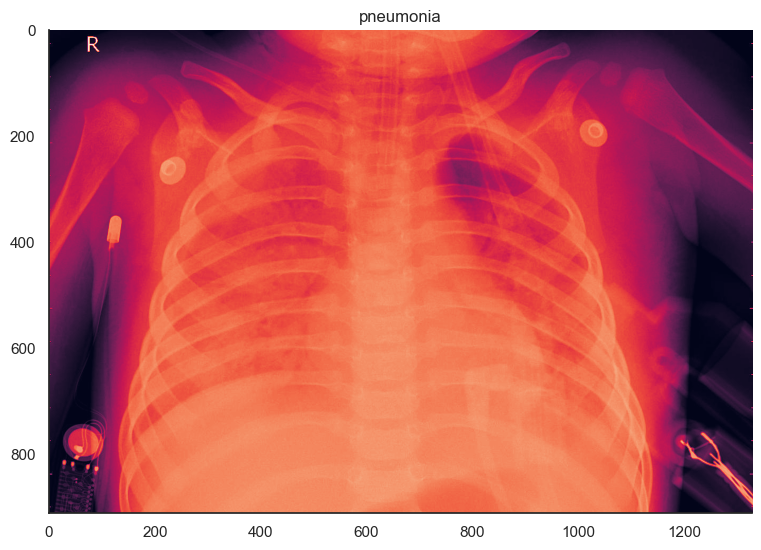

In [41]:
# View image
img = mpimg.imread(test_samples.iloc[0]['filepath'])
plt.imshow(img)
plt.title(test_samples.iloc[0]['label'])
plt.show()

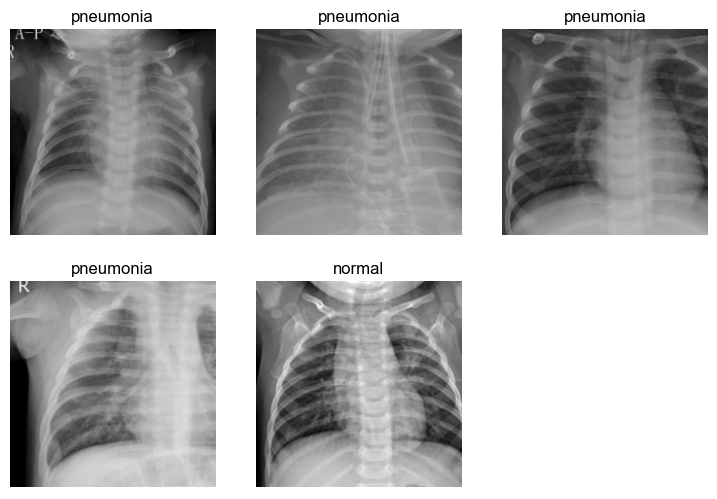

In [17]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader('filepath'),
                   get_y=ColReader('label'),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(200))

dls = dblock.dataloaders(train_samples)

dls.show_batch(max_n=5)

In [25]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
epochs = 5
learn.fine_tune(epochs)

c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,1.141190,2.392188,0.300000,00:18


epoch,train_loss,valid_loss,accuracy,time
0,1.215396,2.511281,0.300000,00:23
1,1.055072,2.565329,0.350000,00:23
2,0.948843,2.865339,0.350000,00:21
3,0.790385,3.189366,0.350000,00:22
4,0.680521,3.022601,0.350000,00:22


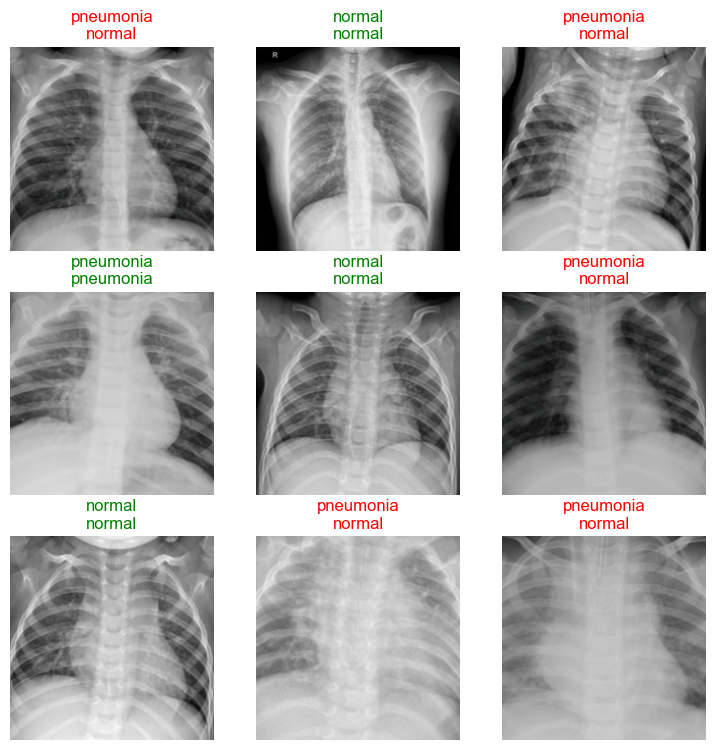

In [26]:
learn.show_results()

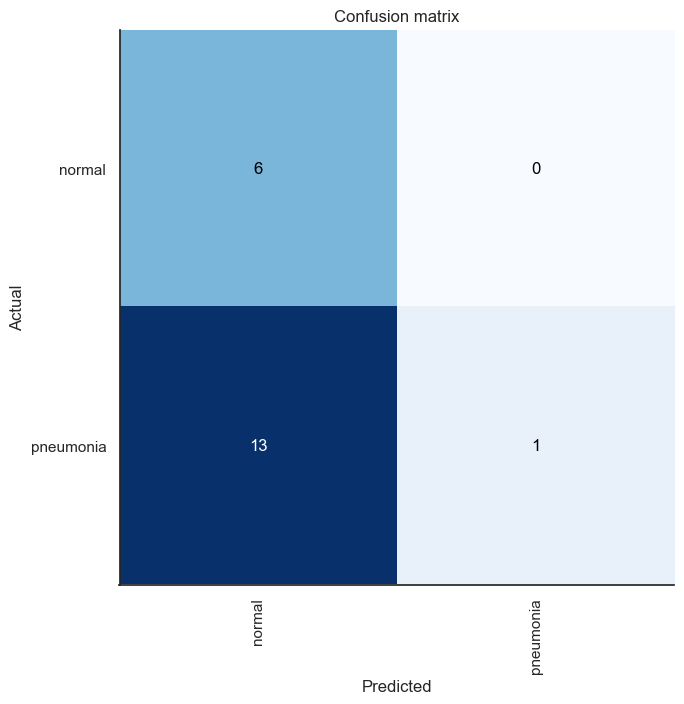

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7, 7));

SuggestedLRs(valley=9.120108734350652e-05)

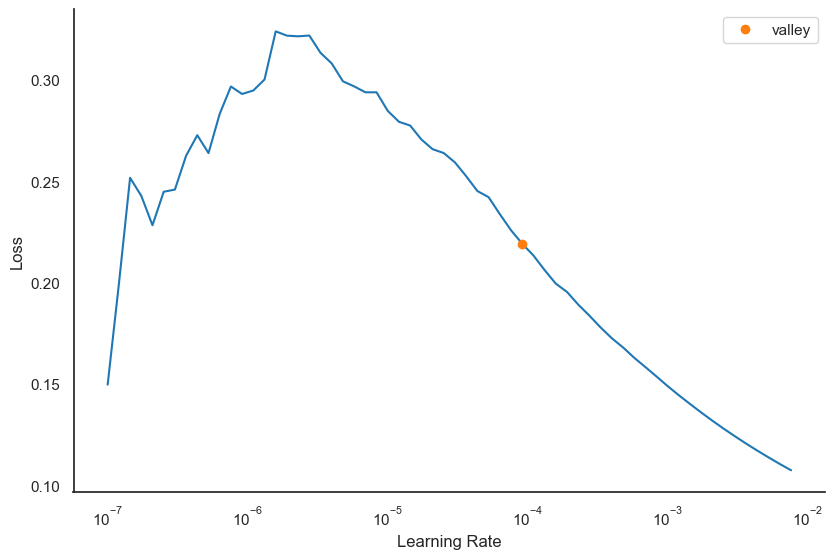

In [28]:
# find best learning rate
learn.lr_find()

In [31]:
lr = 9e-5
epochs = 15
learn.fine_tune(epochs, lr) # retrian with new learning rate 

epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,0.107269,1.035550,0.600000,00:23
1,0.196550,1.020499,0.600000,00:23
2,0.180325,1.002943,0.600000,00:22
3,0.234485,1.012669,0.650000,00:24
4,0.241658,0.997535,0.700000,00:23
5,0.229635,0.989528,0.700000,00:23
6,0.217996,0.988968,0.700000,00:22
7,0.233137,0.971114,0.650000,00:23
8,0.223226,0.976136,0.650000,00:21
9,0.221066,0.945628,0.650000,00:19


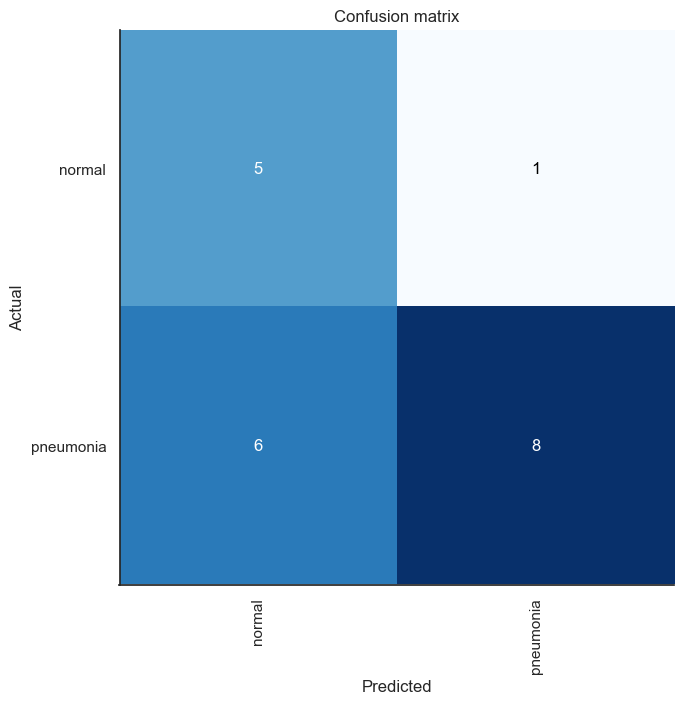

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7, 7));